# **Music Recommendation System**

### **Importing Libraries and the Dataset**

In [1]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings #Used to ignore the warning given as output of the code.
warnings.filterwarnings('ignore')

import numpy as np # Basic libraries of python for numeric and dataframe computations.
import pandas as pd

import matplotlib.pyplot as plt #Basic library for data visualization.
import seaborn as sns #Slightly advanced library for data visualization

from sklearn.metrics.pairwise import cosine_similarity #To compute the cosine similarity between two vectors.
from collections import defaultdict #A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error # A performance metrics in sklearn.

import pickle

In [3]:
#importing the datasets
count_df = pd.read_csv('/content/drive/MyDrive/count_data.csv')
song_df = pd.read_csv('/content/drive/MyDrive/song_data.csv')

In [4]:
# Left merge the count_df and song_df data on "song_id". Drop duplicates from song_df data simultaneously.
df = pd.merge(count_df, song_df.drop_duplicates(subset = ['song_id']), on = 'song_id')
df = df.drop(columns = 'Unnamed: 0')

### **Creating the Shorter Version of the Data (from Milestone 1)**

In [5]:
# Apply label encoding for "user_id" and "song_id"
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['user_id2'] = le.fit_transform(df['user_id'])
df['song_id2'] = le.fit_transform(df['song_id'])

In [6]:
# Get the column containing the users
users = df.user_id
# Create a dictionary from users to their number of songs (We see that how many songs that users have listened?)
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1    

In [7]:
# We want our users to have listened at least 90 songs
RATINGS_CUTOFF = 90
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
df = df.loc[~df.user_id.isin(remove_users)] 

In [8]:
# Get the column containing the songs
songs = df.song_id
# Create a dictionary from songs to their number of users (We can see that songs were played by how many unique users)
ratings_count = dict()
for song in songs:
    # If we already have the song, just add 1 to their rating count
    if song in ratings_count:
        ratings_count[song] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[song] = 1  

In [9]:
# We want our song to be listened by at least 120 users to be considred
RATINGS_CUTOFF = 120
remove_songs = []
for song, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_songs.append(song)
df_final= df.loc[~df.song_id.isin(remove_songs)]

In [10]:
# Drop records with play_count more than(>) 5
df_final= df.drop(df[df['play_count'] > 5].index)

In [11]:
# Check the shape of the data
df_final.shape

(400730, 9)

In [13]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400730 entries, 2 to 1999984
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      400730 non-null  object
 1   song_id      400730 non-null  object
 2   play_count   400730 non-null  int64 
 3   title        400730 non-null  object
 4   release      400730 non-null  object
 5   artist_name  400730 non-null  object
 6   year         400730 non-null  int64 
 7   user_id2     400730 non-null  int64 
 8   song_id2     400730 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 30.6+ MB


In [14]:
with open('/content/drive/MyDrive/recsystem_df_final.pickle', 'wb') as f:  # serializes the data and writes it to the file.
    pickle.dump(df_final, f)

### **Exploratory Data Analysis (from Milestone 1)**

#### Let's check the total number of unique users, songs, artists in the data

Total number of unique user id

In [15]:
# Display total number of unique user_id
df_final.user_id.nunique()

3156

Total number of unique song id

In [16]:
# Display total number of unique song_id
df_final.song_id.nunique()

9998

Total number of unique artists

In [17]:
# Display total number of unique artists
df_final.artist_name.nunique()

3374

####**Observations and Insights:**
- We have 3156 unique users (user_id) in this data set.
- We have 9998 unique songs (song_id) in the data.
- We have 3374 unique artists (artist_name) in the data.



### **Let's find out about the most interacted songs and interacted users**

Most interacted songs

In [18]:
#Top 10 songs that were played the most times
df_final.groupby(['song_id2', 'title', 'release', 'artist_name'])['play_count'].sum().sort_values(ascending = False).reset_index(name = 'count').head(10)

,song_id2,title,release,artist_name,count
0,352,Dog Days Are Over (Radio Edit),Now That's What I Call Music! 75,Florence + The Machine,1634
1,2220,Sehr kosmisch,Musik von Harmonia,Harmonia,1583
2,8582,Use Somebody,Use Somebody,Kings Of Leon,1463
3,5531,Secrets,Waking Up,OneRepublic,1427
4,4448,Fireflies,Karaoke Monthly Vol. 2 (January 2010),Charttraxx Karaoke,1291
5,4152,The Scientist,The Scientist,Coldplay,1259
6,1334,Hey_ Soul Sister,Save Me_ San Francisco,Train,1208
7,1118,Clocks,A Rush Of Blood To The Head,Coldplay,1203
8,8092,OMG,OMG - The Remixes,Usher featuring will.i.am,1126
9,6189,Creep (Explicit),Pablo Honey,Radiohead,1067


In [19]:
#Top 10 songs that were played by the most unique users
df_final.groupby(['song_id', 'title', 'artist_name'])['user_id'].nunique().sort_values(ascending = False).reset_index(name = 'count').head(10)

,song_id,title,artist_name,count
0,SOWCKVR12A8C142411,Use Somebody,Kings Of Leon,751
1,SOAXGDH12A8C13F8A1,Dog Days Are Over (Radio Edit),Florence + The Machine,748
2,SOFRQTD12A81C233C0,Sehr kosmisch,Harmonia,713
3,SOCVTLJ12A6310F0FD,Clocks,Coldplay,662
4,SOKLRPJ12A8C13C3FE,The Scientist,Coldplay,652
5,SONYKOW12AB01849C9,Secrets,OneRepublic,618
6,SOLFXKT12AB017E3E0,Fireflies,Charttraxx Karaoke,609
7,SOPQLBY12A6310E992,Creep (Explicit),Radiohead,606
8,SOPXKYD12A6D4FA876,Yellow,Coldplay,583
9,SODJWHY12A8C142CCE,Hey_ Soul Sister,Train,570


Most interacted users

In [20]:
#Top 10 users that have played (any songs) the most times
df_final.groupby(['user_id2'])['play_count'].sum().sort_values(ascending = False).reset_index(name = 'count').head(10)

,user_id2,count
0,32542,1157
1,75144,1032
2,31704,981
3,10807,903
4,7834,896
5,6480,874
6,52662,835
7,23297,813
8,48273,800
9,20619,732


In [21]:
#Top 10 users that have played the most unique songs
df_final.groupby(['user_id2'])['song_id2'].nunique().sort_values(ascending = False).reset_index(name = 'count').head(10)

,user_id2,count
0,75144,621
1,32542,587
2,23297,531
3,10807,512
4,6480,496
5,52662,488
6,61472,482
7,7834,475
8,23790,472
9,49507,468


####**Observations and Insights:**
- We defined the top 10 most interected songs as the songs that were played the most times. We see that these songs were played at least 2464 times.
- By the above definition, the most interacted song is 'Undo' by the artist 'Björk'. This song were played 5259 times.
- We also defined the top 10 most interected songs as the songs that were played by the most unique users. These songs were played by at least 684 unique users.
- By the above the definition, the most interacted song is 'Dog Days Are Over (Radio Edit)', which were played by the most unique users (1002 users).
- We defined the top 10 most interacted users as people who had the most total plays on the platform. These users have played songs at least 732 times in total on the platform.
- By the above the definition, the most interacted user had the total of 1157 plays on the platform.
- We also defined the top 10 most interacted users as people who have played the most unique songs. These users have broader interests in songs. They have played at least 190 unique songs.

Songs played in a year

In [22]:
count_songs = df_final.groupby('year').count()['title']
count = pd.DataFrame(count_songs)
count.drop(count.index[0], inplace=True)
count.tail()

,title
year,
2006,27371
2007,39409
2008,38090
2009,34390
2010,13809


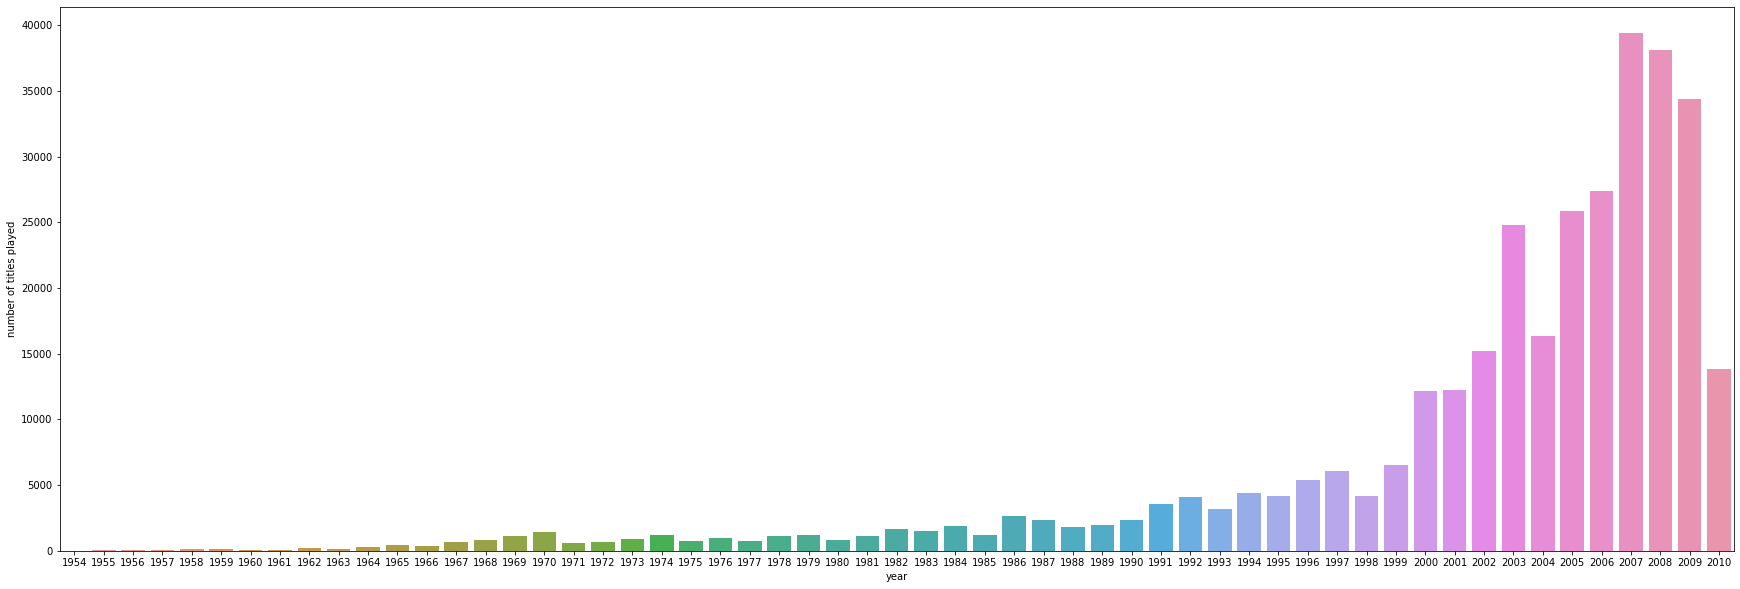

In [23]:
plt.figure(figsize=(30,10))
sns.barplot(x = count.index,
            y = 'title',
            data = count,
            estimator = np.median)
plt.ylabel('number of titles played') 
# Show the plot
plt.show()

####**Observations and Insights:**
- The song count distribution is highly left-skewed. 
- We see that most of the songs (17960 songs) were played in 2009, followed by 2008, 2007, and 2003.
- We see that users rarely listened to songs that were released between 1969 and 1999.

**Think About It:** What other insights can be drawn using exploratory data analysis?

### **Proposed approach**


**Potential techniques** - What different techniques should be explored?<br>
**Overall solution design** - What is the potential solution design?<br>
**Measures of success**- What are the key measures of success to compare different potential technqiues?<br>


# **Milestone 2**

### **Popularity-Based Recommendation Systems**

Let's take the count and sum of play counts of the songs and build the popularity recommendation systems on the basis of the sum of play counts.

In [12]:
#Calculating average play_count
average_count = df_final.groupby('song_id2')['play_count'].mean() #Hint: Use groupby function on the song_id column. 

#Calculating the frequency a song is played.
play_freq = df_final.groupby('song_id2')['play_count'].sum() #Hint: Use groupby function on the song_id column

In [13]:
#Making a dataframe with the average_count and play_freq
final_play = pd.DataFrame({'avg_count': average_count, 'play_freq': play_freq})
final_play.head()

,avg_count,play_freq
song_id2,,
0,1.000000,11
1,1.673913,77
2,2.000000,14
3,2.416667,29
4,1.458333,70


In [17]:
with open('/content/drive/MyDrive/recsystem_final_play.pickle', 'wb') as f:  # serializes the data and writes it to the file.
    pickle.dump(final_play, f)

Now, let's create a function to find the top n songs for a recommendation based on the average play count of song. We can also add a threshold for a minimum number of playcounts for a song to be considered for recommendation.

In [18]:
#Build the function for finding top n songs
def popularity_based(top_n, min_interaction = 50):
  recommendations = final_play[final_play['play_freq'] > min_interaction] 
  recommendations = recommendations.sort_values(by = 'avg_count', ascending = False).head(top_n)
  return recommendations  #Or we can use recommendations.index[:top_n]

In [19]:
#Recommend top 10 songs using the function defined above
%%time
popularity_based(10, 50)

CPU times: user 3.01 ms, sys: 0 ns, total: 3.01 ms
Wall time: 4.07 ms


,avg_count,play_freq
song_id2,,
1226,3.400000,51
7224,3.373832,361
3749,3.368421,64
5310,3.187500,51
4049,2.947368,56
8267,2.900000,58
307,2.884615,75
5269,2.869565,66
7632,2.869565,66


### **User User Similarity-Based Collaborative Filtering**

To build the user-user-similarity based and subsequent models we will use the "surprise" library.

In [15]:
# Import necessary libraries
from surprise import accuracy
from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import KFold
from surprise import CoClustering

### Some useful functions

The below is the function to calculate precision@k and recall@k, RMSE and F1_Score@k to evaluate the model performance.

**Think About It:** Which metric should be used for this problem to compare different models?

In [41]:
#The function to calulate the RMSE, precision@k, recall@k and F_1 score. 
def precision_recall_at_k(model, k=10, threshold=1.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    
    #Making predictions on the test data
    predictions=model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    #Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)),3)
    #Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)),3)

    accuracy.rmse(predictions)
    print('Precision: ', precision) #Command to print the overall precision
    print('Recall: ', recall) #Command to print the overall recall
    print('F_1 score: ', round((2*precision*recall)/(precision+recall),3)) # Formula to compute the F-1 score.

**Think About It:** In the function precision_recall_at_k above the threshold value used is 1.5. How precision and recall are affected by changing the threshold? What is the intuition behind using the threshold value 1.5? 

In [16]:
# Instantiating Reader scale with expected rating scale 
reader = Reader(rating_scale = (0, 5)) #use rating scale (0,5)

# loading the dataset
data = Dataset.load_from_df(df_final[['user_id2', 'song_id2', 'play_count']], reader) #Take only "user_id","song_id", and "play_count"

# splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size = 0.4, random_state = 42) # Take test_size=0.4

**Think About It:** How changing the test size would change the results and outputs?
- As we increase the size of the training data, the bias would increase while the variance would decrease. We need to find a balance when selecting the size of the training and testing data.

### User-user Similarity-based Baseline Model

In [24]:
%%time
from pandas.core.common import random_state
#Build the default user-user-similarity model

sim_options = {'name': 'cosine',
               'user_based': True}

#KNN algorithm is used to find desired similar items.
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1) #use random_state=1 

# Train the algorithm on the trainset, and predict play_count for the testset
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10. (Corrected by me: Should be k = 10)
precision_recall_at_k(sim_user_user) #Use sim_user_user model

RMSE: 1.0919
Precision:  0.404
Recall:  0.263
F_1 score:  0.319
CPU times: user 20.6 s, sys: 231 ms, total: 20.8 s
Wall time: 20.9 s


**Observations and Insights:**
- The RMSE is very high. We use RMSE see how far the overall predicted play counts are from the actual play counts. The lower of the RMSE, the more accurate the model is.
- The model is giving a precision of ~0.40, meaning that out of all the relevant songs 40% are recommended.
- The model is giving a recall of 0.26, meaning that out of all the recommended songs 26% are relevant.
- The baseline model is giving a F_1 score of ~0.32. This means that most of the recommended songs were not relevant or most of the relevant songs were not recommended. 
- We will improve this model by sing GridSearchCV by tuning different hyperparameters of this algorithm.

In [25]:
%%time
#predicting play_count for a sample user with a listened song.
sim_user_user.predict(6958, 1671, r_ui=2, verbose=True) #use user id 6958 and song_id 1671

user: 6958       item: 1671       r_ui = 2.00   est = 1.76   {'actual_k': 40, 'was_impossible': False}
CPU times: user 1.71 ms, sys: 0 ns, total: 1.71 ms
Wall time: 1.6 ms


Prediction(uid=6958, iid=1671, r_ui=2, est=1.7584230873321858, details={'actual_k': 40, 'was_impossible': False})

In [26]:
%%time
#predicting play_count for a sample user with a song not-listened by the user.
sim_user_user.predict(6958, 3232, verbose=True) #Use user_id 6958 and song_id 3232

user: 6958       item: 3232       r_ui = None   est = 1.57   {'actual_k': 40, 'was_impossible': False}
CPU times: user 2.82 ms, sys: 0 ns, total: 2.82 ms
Wall time: 2.72 ms


Prediction(uid=6958, iid=3232, r_ui=None, est=1.5698113325312941, details={'actual_k': 40, 'was_impossible': False})

**Observations and Insights:**
- The first output shows that the predicted play count (1.76) is close to the actual play count (2.00) based on thee user-user similarity-based baseline model.
- The predicted play count for the user id 6958 to listen to the song id 3232 is 1.57.

Now, let's try to tune the model and see if we can improve the model performance.

### Improve the user-user baseline model by using GridSearchCV

In [27]:
%%time
# setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
               'sim_options': {'name': ["cosine",'pearson',"pearson_baseline"],
                               'user_based': [True], "min_support":[2,4]}
               }

# performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
# fitting the data
gs.fit(data) #Use entire data for GridSearch

# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0533694237450157
{'k': 30, 'min_k': 9, 'sim_options': {'name': 'pearson_baseline', 'user_based': True, 'min_support': 2}}
CPU times: user 26min 28s, sys: 9.81 s, total: 26min 38s
Wall time: 45min 57s


In [28]:
import pickle
with open('/content/drive/MyDrive/recsystem_gs.pickle', 'wb') as f:  # serializes the data and writes it to the file.
    pickle.dump(gs, f)

In [29]:
# Train the best model found in above gridsearch.
sim_options = {'name': 'pearson_baseline',
               'user_based': True, 'min_support': 2}

sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 9, verbose = False, random_state = 1)

sim_user_user_optimized.fit(trainset)

precision_recall_at_k(sim_user_user_optimized)

RMSE: 1.0546
Precision:  0.448
Recall:  0.29
F_1 score:  0.352


In [30]:
with open('/content/drive/MyDrive/recsystem_sim_user_user_optimized.pickle', 'wb') as f:  # serializes the data and writes it to the file.
    pickle.dump(sim_user_user_optimized, f)

**Observations and Insights:**
- The RMSE of the optimized model decrease slightly in comparison to the baseline model.
- After tuning hyperparameters, the precision and recall both slightly increase. Due to this, F_1 score of the tuned model has increased slightly as well comparing to the baseline model. 
- We can say that the model performance has improved slightly after hyperparameter tuning.

In [31]:
with open('/content/drive/MyDrive/recsystem_sim_user_user_optimized.pickle', 'rb') as f: 
    uu_tuned = pickle.load(f)

In [32]:
#Predict the play count for a user who has listened to the song. Take user_id 6958, song_id 1671 and r_ui=2
uu_tuned.predict(6958, 1671, r_ui=2, verbose=True) 

user: 6958       item: 1671       r_ui = 2.00   est = 1.85   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.8514963400242335, details={'actual_k': 30, 'was_impossible': False})

In [33]:
#Predict the play count for a song that is not listened by the user (with user_id 6958)
uu_tuned.predict(6958, 3232, verbose=True) 

user: 6958       item: 3232       r_ui = None   est = 1.38   {'actual_k': 16, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.3768798844353598, details={'actual_k': 16, 'was_impossible': False})

**Observations and Insights:**
- Based on the tuned user-user similarity-based model, the predicted play count of the song id 1671 for the user id 6958 is 1.85, which is closer to the actual rating (2.00) in comparison to the baseline model (1.76). 
- From the above bullet, we see that the predicted play count has been improved after hyperparameter tuning.
- We also see that the predicted play count for the song (with id 3232) that the user has not listened to has been slightly decreased in comparison to the baseline model (1.57).

**Think About It:** Along with making predictions on listened and unknown songs can we get 5 nearest neighbors (most similar) to a certain user?

In [34]:
#Use inner id 0. 
uu_tuned.get_neighbors(0, k = 5)

[1654, 247, 607, 594, 1522]

Below we will be implementing a function where the input parameters are - 

- data: a **song** dataset
- user_id: a user id **against which we want the recommendations**
- top_n: the **number of songs we want to recommend**
- algo: the algorithm we want to use **for predicting the play_count**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [29]:
def get_recommendations(data, user_id, top_n, algo):
    
    # creating an empty list to store the recommended product ids
    recommendations = []
    
    # creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot_table(index = 'user_id2', columns = 'song_id2', values = 'play_count')
    
    # extracting those business ids which the user_id has not visited yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # looping through each of the business ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # predicting the ratings for those non visited restaurant ids by this user
        est = algo.predict(user_id, item_id).est
        
        # appending the predicted ratings
        recommendations.append((item_id, est))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating products for this user

In [37]:
# Making top 10 recommendations for userId 4 using the similarity-based recommendation system
recommendations = get_recommendations(df_final, 6958, 10, uu_tuned)

In [38]:
#Building the dataframe for above recommendations with columns "song_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['song_id2', 'predicted_ratings'])

,song_id2,predicted_ratings
0,5167,3.707928
1,4831,2.969960
2,6867,2.924768
3,8524,2.906132
4,6478,2.860159
5,9070,2.837769
6,8610,2.681107
7,8866,2.652514
8,6378,2.638556
9,4811,2.618978


**Observations and Insights:**
- The predicted play counts of the top 10 recommended songs for the user id 6958 are at least ~2.62 times. 
- The first most recommended song for the user id 6958 has the play count of ~3.70.

### Correcting the play_counts and Ranking the above songs

In [39]:
def ranking_songs(recommendations, final_rating):
  # sort the songs based on play counts
  ranked_songs = final_rating.loc[[items[0] for items in recommendations]].sort_values('play_freq', ascending=False)[['play_freq']].reset_index()

  # merge with the recommended songs to get predicted play_count
  ranked_songs = ranked_songs.merge(pd.DataFrame(recommendations, columns=['song_id2', 'predicted_ratings']), on='song_id2', how='inner')

  # rank the songs based on corrected play_counts
  ranked_songs['corrected_ratings'] = ranked_songs['predicted_ratings'] - 1 / np.sqrt(ranked_songs['play_freq'])

  # sort the songs based on corrected play_counts
  ranked_songs = ranked_songs.sort_values('corrected_ratings', ascending = False)
  
  return ranked_songs

**Think About It:** In the above function to make the correction in the predicted play_count a quantity 1/np.sqrt(n) is subtracted. What is the intuition behind it? Is it also possible to add this quantity instead of subtracting?
- We are subtracting this quantity 1/np.sqrt(n) to get more optimistic predictions, as there are some songs with ratings of 5 and we can't have a rating more than 5 for a song.

In [40]:
#Applying the ranking_songs function on the final_play data. 
ranking_songs(recommendations, final_play)

,song_id2,play_freq,predicted_ratings,corrected_ratings
8,5167,93,3.707928,3.604233
5,4831,214,2.969960,2.901602
9,6867,91,2.924768,2.819939
7,8524,113,2.906132,2.812060
4,6478,229,2.860159,2.794077
6,9070,135,2.837769,2.751703
0,8610,435,2.681107,2.633161
3,8866,259,2.652514,2.590377
1,6378,375,2.638556,2.586916
2,4811,332,2.618978,2.564096


**Observations and Insights:**
- Apart from the predicted rating, the number of times that the songs were played become important to consider. Due to this, we have calculated the "corrected_ratings" for each song by subtracting the quantity 1/np.sqrt(n) to get more optimistic predictions.
- From the "corrected_ratings" column, we see that the predicted play counts of these songs are at least ~2.56 times. The most recommended song has a play count of 3.60.  

### **Item Item Similarity-based collaborative filtering recommendation systems** 

In [41]:
%%time
#Apply the item-item similarity collaborative filtering model with random_state=1 and evaluate the model performance.
sim_options = {'name': 'cosine',
               'user-based': False}

sim_item_item = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

sim_item_item.fit(trainset)

precision_recall_at_k(sim_item_item)

RMSE: 1.0919
Precision:  0.404
Recall:  0.263
F_1 score:  0.319
CPU times: user 20.9 s, sys: 308 ms, total: 21.2 s
Wall time: 21.5 s


In [42]:
with open('/content/drive/MyDrive/recsystem_sim_item_item.pickle', 'wb') as f:  # serializes the data and writes it to the file.
    pickle.dump(sim_item_item, f)

**Observations and Insights:**
- The RMSE, precision, recall and F_1 score by the item-item similarity-based baseline model is the same as the user-user similarity-based basedline model.

In [43]:
%%time
#predicting play count for a sample user_id 6958 and song (with song_id 1671) heard by the user.
sim_item_item.predict(6958, 1671, r_ui=2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.76   {'actual_k': 40, 'was_impossible': False}
CPU times: user 1.71 ms, sys: 0 ns, total: 1.71 ms
Wall time: 1.5 ms


Prediction(uid=6958, iid=1671, r_ui=2, est=1.7584230873321858, details={'actual_k': 40, 'was_impossible': False})

In [44]:
df_final[df_final.song_id2 != 1671].head() #Find user who has not listened to the song (with song_id 1671)

,user_id,song_id,play_count,title,release,artist_name,year,user_id2,song_id2
2,76235885b32c4e8c82760c340dc54f9b608d7d7e,SOAKIMP12A8C130995,3,The Cove,Thicker Than Water,Jack Johnson,0,35091,153
8,be21ec120193effd2a5e545c4bafa2e1f92e9816,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0,56747,153
9,6fbb9ff93663f3c3ad206a9325d90b19278618b4,SOAKIMP12A8C130995,2,The Cove,Thicker Than Water,Jack Johnson,0,33217,153
19,95e83cfc3710f2b3ef069d8918ddbc98fc2c7c70,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0,44790,153
22,00af94bc896536ec6390ad8d9026ba42f8c1577d,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0,169,153


In [45]:
%%time
#Predict the play count for a user that has not listened to the song (with song_id 1671)
sim_item_item.predict(35091, 1671, verbose = True) # Select a random user

user: 35091      item: 1671       r_ui = None   est = 1.33   {'actual_k': 40, 'was_impossible': False}
CPU times: user 1.59 ms, sys: 0 ns, total: 1.59 ms
Wall time: 4.42 ms


Prediction(uid=35091, iid=1671, r_ui=None, est=1.325456054340431, details={'actual_k': 40, 'was_impossible': False})

**Observations and Insights:**
- The predicted play count by the item-item similarity-based baseline model is the same as the user-user similarity-based baseline model.
- However, it has slightly decreased in comparison to the user-user similarity-based tuned model.

###Improve the item-item baseline model by using GridSearchCV

In [46]:
#Apply grid search for enhancing model performance

#setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ["cosine",'pearson',"pearson_baseline"],
                              'user_based': [False], "min_support":[2,4]}
              }
                    
# performing 3-fold cross validation to tune the hyperparameters
gs_ii = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = 1, joblib_verbose=3)

# fitting the data
gs_ii.fit(data)

# find best RMSE score
print(gs_ii.best_score['rmse'])
      
# Extract the combination of parameters that gave the best RMSE score
print(gs_ii.best_params['rmse'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Computing the cosine similarity matrix...
Done computing similarity matrix.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.1s remaining:    0.0s


Computing the cosine similarity matrix...
Done computing similarity matrix.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   56.4s remaining:    0.0s


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 75.2min finished


In [47]:
with open('/content/drive/MyDrive/recsystem_gs_ii.pickle', 'wb') as f:  # serializes the data and writes it to the file.
    pickle.dump(gs_ii, f)

### Apply the best hyperparameters to the model

**Think About It:** How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the list of hyperparameter [here](https://surprise.readthedocs.io/en/stable/knn_inspired.html).

In [48]:
# Apply the best model found in the grid search.
sim_options = {'name': 'pearson_baseline', 'user_based': False,
               'min_support': 2}

sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 6, verbose = False, random_state = 1)

sim_item_item_optimized.fit(trainset)

precision_recall_at_k(sim_item_item_optimized)

RMSE: 1.0222
Precision:  0.464
Recall:  0.286
F_1 score:  0.354


In [49]:
with open('/content/drive/MyDrive/recsystem_ii_optimized.pickle', 'wb') as f:  # serializes the data and writes it to the file.
    pickle.dump(sim_item_item_optimized, f)

**Observations and Insights:**
- The RMSE by the tuned model has slightly decreased in comparison to the item-item similarity-based baseline model.
- We see that the precision, recall, and F_1 score have all slightly increased in comparison to the item-iten similarity-based baseline model. We can say that the model performance has improved after hyperparameter tuning.
- The F_1 score by this tuned model (0.354) is slightly higher than the user-user similarity-based tuned model (0.352). 

In [50]:
with open('/content/drive/MyDrive/recsystem_ii_optimized.pickle', 'rb') as f:  
    ii_optimized = pickle.load(f)

In [51]:
#Predict the play_count by a user(user_id 6958) for the song (song_id 1671)
ii_optimized.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 2.06   {'actual_k': 25, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=2.0552521744973915, details={'actual_k': 25, 'was_impossible': False})

In [52]:
#predicting play count for a sample user_id 6958 with song_id 3232 which is not heard by the user.
ii_optimized.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.03   {'actual_k': 16, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.0348246019959535, details={'actual_k': 16, 'was_impossible': False})

**Observations and Insights:**
- The predicted play count of the song id 1671 for the user id 6958 is 2.06, which is closer to the actual play count (2.00).
- The predicted play count of the song (with id 3232) that the user has not listened to has decreased in comparison to the item-item similarity-based baseline model, the oprimized user-user similarity-based model, and the user-user similarity-based baseline model.

In [53]:
#Find five most similar users to the user with inner id 0
ii_optimized.get_neighbors(0, k = 5)

[201, 247, 237, 5635, 638]

In [54]:
#Making top 10 recommendations for user_id 6958 with item_item_similarity-based recommendation engine.
recommendations = get_recommendations(df_final, 6958, 10, ii_optimized)

In [56]:
#Building the dataframe for above recommendations with columns "song_id" and "predicted_play_count"
pd.DataFrame(recommendations, columns = ['song_id2', 'predicted_play_count'])

,song_id2,predicted_play_count
0,9878,3.638057
1,9708,3.430311
2,7437,3.299636
3,8026,3.191702
4,9117,3.125370
5,1386,3.063164
6,9480,3.048665
7,4134,3.000234
8,4970,2.943083
9,8610,2.886053


In [57]:
#Applying the ranking_songs function. 
ranking_songs(recommendations, final_play)

,song_id2,play_freq,predicted_ratings,corrected_ratings
4,9878,83,3.638057,3.528293
1,9708,389,3.430311,3.379609
7,7437,71,3.299636,3.180958
8,8026,60,3.191702,3.062602
5,9117,77,3.125370,3.011409
3,1386,119,3.063164,2.971494
2,4134,240,3.000234,2.935684
9,9480,52,3.048665,2.909990
0,8610,435,2.886053,2.838107
6,4970,73,2.943083,2.826042


**Observations and Insights:**
- The corrected play count of the top 10 recommended songs by this tuned model are at least 2.83, which is higher than the item-item similarity-based baseline model.
- The corrected play count of the top 1 recommended song by this tuned model is ~3.53, which is lower than the item-item similarity-based baseline model.

### **Model Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

In [58]:
%%time
# Build baseline model using svd
svd = SVD(random_state = 1)

svd.fit(trainset)

precision_recall_at_k(svd)

RMSE: 1.0295
Precision:  0.42
Recall:  0.25
F_1 score:  0.313
CPU times: user 19.4 s, sys: 103 ms, total: 19.5 s
Wall time: 19.5 s


In [59]:
with open('/content/drive/MyDrive/recsystem_svd.pickle', 'wb') as f:  # serializes the data and writes it to the file.
    pickle.dump(svd, f)

In [60]:
with open('/content/drive/MyDrive/recsystem_svd.pickle', 'rb') as f:  
    svd_base = pickle.load(f)

In [61]:
%%time
# Making prediction for user (with user_id 6958) to song (with song_id 1671), take r_ui=2
svd_base.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.62   {'was_impossible': False}
CPU times: user 222 µs, sys: 0 ns, total: 222 µs
Wall time: 229 µs


Prediction(uid=6958, iid=1671, r_ui=2, est=1.6221505969477434, details={'was_impossible': False})

In [62]:
%%time
# Making prediction for user who has not listened the song (song_id 3232)
svd_base.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.32   {'was_impossible': False}
CPU times: user 2.33 ms, sys: 0 ns, total: 2.33 ms
Wall time: 8.36 ms


Prediction(uid=6958, iid=3232, r_ui=None, est=1.32219833713367, details={'was_impossible': False})

#### Improving matrix factorization based recommendation system by tuning its hyperparameters

In [19]:
%%time
# set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# performe 3-fold gridsearch cross validation
gs_svd = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# fitting data
gs_svd.fit(data)
# best RMSE score
print(gs_svd.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs_svd.best_params['rmse'])

1.018961898635866
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}
CPU times: user 13min 34s, sys: 4.7 s, total: 13min 39s
Wall time: 28min 56s


In [64]:
with open('/content/drive/MyDrive/recsystem_gs_svd.pickle', 'wb') as f:  # serializes the data and writes it to the file.
    pickle.dump(gs_svd, f)

**Think About It**: How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the available hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html).

In [65]:
# Building the optimized SVD model using optimal hyperparameters
svd_optimized = SVD(n_epochs = 10, lr_all =  0.005, reg_all = 0.2, random_state = 1)

svd_optimized = svd_optimized.fit(trainset)

precision_recall_at_k(svd_optimized)

RMSE: 1.0177
Precision:  0.419
Recall:  0.247
F_1 score:  0.311


In [66]:
with open('/content/drive/MyDrive/recsystem_svd_optimized.pickle', 'wb') as f:  # serializes the data and writes it to the file.
    pickle.dump(svd_optimized, f)

**Observations and Insights:**
- The RMSE by the tuned SVD model has slightly decreased in comparison to the SVD model with default hyperparameters. 
- The precison, recall, and F_1 score by the tuned SVD model have slightly decreased in comparison to the SVD model with default hyperparameters. Due to this, we can see that the model performance has not improved.

In [67]:
with open('/content/drive/MyDrive/recsystem_svd_optimized.pickle', 'rb') as f:
    svd_tuned = pickle.load(f)

In [68]:
#Using svd_algo_optimized model to recommend for userId 6958 and song_id 1671.
svd_tuned.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.46   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.460177908120248, details={'was_impossible': False})

In [69]:
#Using svd_algo_optimized model to recommend for userId 6958 and song_id 3232 with unknown baseline rating.
svd_tuned.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.44   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.4396992501712476, details={'was_impossible': False})

**Observations and Insights:**
- Based on the optimized SVD model, the predicted play count of the song id 1671 for the user id 6958 is 1.46, which is relateively far away from the actual play count (2.00).
- We see that the predicted play count of the song id 3232 has slightly increased in comparison to the SVD baseline model, the optimized item-item similarity-based model, the item-item similarity-based basedline model, and the optimized user-user similarity-based model.

In [70]:
# Getting top 10 recommendations for user_id 6958 using "svd_optimized" algorithm.
svd_recommendations = get_recommendations(df_final, 6958, 10, svd_tuned)

In [71]:
#Ranking songs based on above recommendations
ranking_songs(svd_recommendations, final_play)

,song_id2,play_freq,predicted_ratings,corrected_ratings
0,7224,361,3.085442,3.032810
2,6450,263,2.409984,2.348321
9,3987,42,2.417126,2.262823
3,4237,138,2.301789,2.216663
1,657,335,2.204037,2.149401
4,5116,79,2.247245,2.134736
7,6574,62,2.260290,2.133290
5,5840,69,2.248916,2.128531
6,7632,66,2.230814,2.107722
8,5614,59,2.207589,2.077401


**Observations and Insights:**
- The corrected ratings of the top 10 recommended songs by the tuned SVD model are at least ~2.10 and at most 3.03, which are relatively lower than the predictions we made by the models so far.

### **Cluster Based Recommendation System**

In **clustering-based recommendation systems**, we explore the **similarities and differences** in people's tastes in songs based on how they rate different songs. We cluster similar users together and recommend songs to a user based on play_counts from other users in the same cluster.

In [72]:
%%time
# Make baseline clustering model
clust_base = CoClustering(random_state = 1)

clust_base.fit(trainset)

#precision_recall_at_k(clust_base)

CPU times: user 8.16 s, sys: 262 ms, total: 8.42 s
Wall time: 8.19 s


In [73]:
with open('/content/drive/MyDrive/recsystem_clust_base.pickle', 'wb') as f: 
  pickle.dump(clust_base, f)

In [74]:
with open('/content/drive/MyDrive/recsystem_clust_base.pickle', 'rb') as f: 
  clust_base_model = pickle.load(f)

In [75]:
precision_recall_at_k(clust_base_model)

RMSE: 1.0611
Precision:  0.411
Recall:  0.245
F_1 score:  0.307


In [76]:
%%time
#Making prediction for user_id 6958 and song_id 1671.
clust_base_model.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.11   {'was_impossible': False}
CPU times: user 231 µs, sys: 2 µs, total: 233 µs
Wall time: 204 µs


Prediction(uid=6958, iid=1671, r_ui=2, est=1.1077723840944176, details={'was_impossible': False})

In [77]:
%%time
#Making prediction for user (userid 6958) for a song(song_id 3232) not heard by the user.
clust_base_model.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.14   {'was_impossible': False}
CPU times: user 856 µs, sys: 0 ns, total: 856 µs
Wall time: 736 µs


Prediction(uid=6958, iid=3232, r_ui=None, est=1.1369612527565696, details={'was_impossible': False})

#### Improving clustering-based recommendation system by tuning its hyper-parameters

In [20]:
%%time
# set the parameter space to tune
param_grid = {'n_cltr_u':[5,6,7,8], 'n_cltr_i': [5,6,7,8], 'n_epochs': [10,20,30]}

# performing 3-fold gridsearch cross validation
gs_clust = GridSearchCV(CoClustering, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# fitting data
gs_clust.fit(data)


CPU times: user 22min 42s, sys: 5.85 s, total: 22min 48s
Wall time: 24min 36s


In [79]:
with open('/content/drive/MyDrive/recsystem_gs_clust.pickle', 'rb') as f: 
  gs_clust_model = pickle.load(f)

In [80]:
# best RMSE score
print(gs_clust_model.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs_clust_model.best_params['rmse'])

1.0769099053145428
{'n_cltr_u': 5, 'n_cltr_i': 5, 'n_epochs': 10}


**Think About It**: How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the available hyperparameters [here](https://surprise.readthedocs.io/en/stable/co_clustering.html).

In [81]:
# Train the tuned Coclustering algorithm
clust_optimized = CoClustering(n_cltr_u = 5, n_cltr_i = 5, n_epochs = 10, random_state = 1)

clust_optimized.fit(trainset)

precision_recall_at_k(clust_optimized)

RMSE: 1.0911
Precision:  0.406
Recall:  0.234
F_1 score:  0.297


In [84]:
with open('/content/drive/MyDrive/recsystem_clust_optimized.pickle', 'wb') as f: 
  pickle.dump(clust_optimized, f)

**Observations and Insights:**
- The RMSE for the tuned co-clustering model is slightly higher than the co-clustering baseline model.
- The precision, recall, and F_1 score have slightly decreased in comparison to the co-clustering baseline model.
- We see that the model performance has not improved comparing to the co-clustering baseline model.
- The F_1 score for the tuned co-clustering model is the lowest so far comparing to the models we've built so far.

In [82]:
#Using co_clustering_optimized model to recommend for userId 6958 and song_id 1671.
clust_optimized.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.18   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.1812374040085811, details={'was_impossible': False})

In [83]:
#Use Co_clustering based optimized model to recommend for userId 6958 and song_id 3232 with unknown baseline rating.
clust_optimized.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 2.26   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=2.2585390916325796, details={'was_impossible': False})

**Observations and Insights:**
- The predicted play count of the song id 1671 for the user id 6958 is 1.18, which is the lowest so far in comparison to the models we have built so far.
- The predicted play count of the song id 3232 has greatly increased in compariosn to the models we have built so far.

#### Implementing the recommendation algorithm based on optimized CoClustering model

In [85]:
# #Getting top 10 recommendations for user_id 6958 using "Co-clustering based optimized" algorithm.
clustering_recommendations = get_recommendations(df_final, 6958, 10, clust_optimized)

In [86]:
#Applying the ranking_songs function. 
ranking_songs(clustering_recommendations, final_play)

,song_id2,play_freq,predicted_ratings,corrected_ratings
0,1778,31,4.671872,4.492267
5,7561,15,4.671872,4.413674
9,150,8,4.731799,4.378246
8,4916,9,4.671872,4.338539
1,880,24,4.421872,4.217748
3,4001,19,4.395030,4.165614
6,4840,14,4.395030,4.127768
2,192,20,4.338539,4.114932
4,3195,19,4.338539,4.109123
7,7679,12,4.395030,4.106354


### Correcting the play_count and Ranking the above songs

In [87]:
#Ranking songs based on above recommendations
ranking_songs(clustering_recommendations, final_play)

,song_id2,play_freq,predicted_ratings,corrected_ratings
0,1778,31,4.671872,4.492267
5,7561,15,4.671872,4.413674
9,150,8,4.731799,4.378246
8,4916,9,4.671872,4.338539
1,880,24,4.421872,4.217748
3,4001,19,4.395030,4.165614
6,4840,14,4.395030,4.127768
2,192,20,4.338539,4.114932
4,3195,19,4.338539,4.109123
7,7679,12,4.395030,4.106354


**Observations and Insights:**
- The corrected ratings by the tuned co-clustering model are relatively higher than the models we have built so far. The corrected play counts of the top 10 songs are at least ~4.11 and at most 4.49.

### **Content Based Recommendation Systems**

**Think About It:** So far we have only used the play_count of songs to find recommendations but we have other information/features on songs as well. Can we take those song features into account?

In [88]:
df_small=df_final

In [89]:
# Concatenate the "title","release","artist_name" columns to create a different column named "text"
df_small['text'] = df_small['title'] + ' ' + df_small['release'] + ' ' + df_small['artist_name']
df_small.head()

,user_id,song_id,play_count,title,release,artist_name,year,user_id2,song_id2,text
2,76235885b32c4e8c82760c340dc54f9b608d7d7e,SOAKIMP12A8C130995,3,The Cove,Thicker Than Water,Jack Johnson,0,35091,153,The Cove Thicker Than Water Jack Johnson
8,be21ec120193effd2a5e545c4bafa2e1f92e9816,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0,56747,153,The Cove Thicker Than Water Jack Johnson
9,6fbb9ff93663f3c3ad206a9325d90b19278618b4,SOAKIMP12A8C130995,2,The Cove,Thicker Than Water,Jack Johnson,0,33217,153,The Cove Thicker Than Water Jack Johnson
19,95e83cfc3710f2b3ef069d8918ddbc98fc2c7c70,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0,44790,153,The Cove Thicker Than Water Jack Johnson
22,00af94bc896536ec6390ad8d9026ba42f8c1577d,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0,169,153,The Cove Thicker Than Water Jack Johnson


In [90]:
#Select the columns 'user_id', 'song_id', 'play_count', 'title', 'text' from df_small data
df_small = df_small[['user_id2', 'song_id2', 'play_count', 'title', 'text']]

#drop the duplicates from the title column
df_small = df_small.drop_duplicates(subset = ['title'])

#Set the title column as the index
df_small = df_small.set_index('title')

# see the first 5 records of the df_small dataset
df_small.head()

,user_id2,song_id2,play_count,text
title,,,,
The Cove,35091,153,3,The Cove Thicker Than Water Jack Johnson
Entre Dos Aguas,52265,413,1,Entre Dos Aguas Flamenco Para Niños Paco De Lucia
Stronger,39814,736,1,Stronger Graduation Kanye West
Constellations,57932,750,1,Constellations In Between Dreams Jack Johnson
Learn To Fly,75901,1188,2,Learn To Fly There Is Nothing Left To Lose Foo...


In [91]:
# Let us see the shape of final_ratings data
df_small.shape

(9566, 4)

In [92]:
# Create the series of indices from the data
indices = pd.Series(df_small.index)
indices[:5]

0           The Cove
1    Entre Dos Aguas
2           Stronger
3     Constellations
4       Learn To Fly
Name: title, dtype: object

In [93]:
#Importing necessary packages to work with text data
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
import re
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


We will create a **function to pre-process the text data:**

In [94]:
# Function to tokenize the text
def tokenize(text):
    text = re.sub(r"[^a-zA-Z]"," ",text.lower())
    tokens = word_tokenize(text)
    words = [word for word in tokens if word not in stopwords.words('english')] #Use stopwords of english
    text_lems = [WordNetLemmatizer().lemmatize(lem).strip() for lem in words]

    return text_lems

In [95]:
%%time
#Create tfidf vectorizer 
tfidf = TfidfVectorizer(tokenizer = tokenize)

# Fit_transfrom the above vectorizer on the text column and then convert the output into an array.
song_tfidf = tfidf.fit_transform(df_small['text'].values).toarray()

CPU times: user 12.9 s, sys: 2.35 s, total: 15.2 s
Wall time: 15.2 s


In [96]:
# Making the DataFrame of movie_tfidf data
pd.DataFrame(song_tfidf)

,0,1,2,3,4,5,6,7,8,9,...,11284,11285,11286,11287,11288,11289,11290,11291,11292,11293
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
with open('/content/drive/MyDrive/recsystem_song_tfidf.pickle', 'wb') as f:  # serializes the data and writes it to the file.
  pickle.dump(song_tfidf, f)

In [98]:
%%time
# Compute the cosine similarity for the tfidf above output
similar_songs = cosine_similarity(song_tfidf, song_tfidf)

CPU times: user 1min, sys: 3.74 s, total: 1min 4s
Wall time: 36.7 s


In [99]:
similar_songs

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

 Finally, let's create a function to find most similar songs to recommend for a given song

In [100]:
# function that takes in song title as input and returns the top 10 recommended songs
def recommendations(title, similar_songs):
    
    recommended_songs = []
    
    # gettin the index of the song that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(similar_songs[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar songs
    top_10_indexes = list(score_series.iloc[1:11].index)
    print(top_10_indexes)
    
    # populating the list with the titles of the best 10 matching songs
    for i in top_10_indexes:
        recommended_songs.append(list(df_small.index)[i])
        
    return recommended_songs

Recommending 10 songs similar to Learn to Fly

In [101]:
%%time
# Make the recommendation for the song with title 'Learn To Fly'
song_recommendations = recommendations('Learn To Fly', similar_songs)

[18, 35, 7, 2866, 8473, 7487, 4610, 7497, 4593, 8470]
CPU times: user 21.2 ms, sys: 0 ns, total: 21.2 ms
Wall time: 24.3 ms


In [102]:
# Output the top 10 recommendations
song_recommendations

['Breakout',
 'Generator',
 'Stacked Actors',
 'Big Me',
 'For All The Cows',
 'Exhausted',
 'Wattershed',
 'Floaty',
 'Oh_ George',
 'X-Static']

### Compare the top 10 recommended songs

In [103]:
#Append the song we want to make prediction for. 
song_recommendations.append('Learn To Fly')

In [104]:
#Compare its content with the other 10 recommended songs' content.
song_list = pd.DataFrame(song_recommendations, columns = ['title'])
song_list = pd.merge(song_list, df_final[['title', 'release', 'artist_name', 'year', 'user_id2', 'song_id2']].drop_duplicates(subset=['title']), on = 'title', how = 'inner')

total_play_count = df_final.groupby('song_id2')['play_count'].sum().reset_index()
song_list = song_list.merge(total_play_count, on = 'song_id2', how = 'inner')

song_list

,title,release,artist_name,year,user_id2,song_id2,play_count
0,Breakout,There Is Nothing Left To Lose,Foo Fighters,1999,56747,5034,92
1,Generator,There Is Nothing Left To Lose,Foo Fighters,1999,75901,8300,80
2,Stacked Actors,There Is Nothing Left To Lose,Foo Fighters,1999,56747,2056,50
3,Big Me,Foo Fighters,Foo Fighters,1992,75901,7091,210
4,For All The Cows,Foo Fighters,Foo Fighters,1992,56230,8152,52
5,Exhausted,Foo Fighters,Foo Fighters,1995,23297,5349,53
6,Wattershed,Foo Fighters,Foo Fighters,1995,75901,8167,38
7,Floaty,Foo Fighters,Foo Fighters,1995,23297,8478,59
8,Oh_ George,Foo Fighters,Foo Fighters,1995,75901,4041,48
9,X-Static,Foo Fighters,Foo Fighters,1995,31911,543,46


**Observations and Insights:**
- The song 'Learn To Fly' is from the release 'There Is Nothing Left To Lose', which is sung by the artist 'Foo Fighters'. 
- We see that the majority of our recommendations lie in similar genre as they were sung by the same artist 'Foo Fighters'.
- This implies that the resulting recommendation system is working well.

### **Conclusion and Recommendations:** 

- **Refined Insights -** What are the most meaningful insights from the data relevant to the problem?

- **Comparison of various techniques and their relative performance -** How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

- **Proposal for the final solution design -** What model do you propose to be adopted? Why is this the best solution to adopt?

## **Further Analysis**

### **Intersection Rate Analysis**

In [19]:
def intersection_rate(model_1, model_2, input_df):
  id_list = input_df['user_id2'].unique().tolist()
  pivot_df = input_df.pivot_table(index = 'user_id2', columns = 'song_id2', values = 'play_count')
  rate_list = []
  # df1 = get_recommendations(input_df, 6958, 10, model_1)
  for uid in id_list:
    df1 = pd.DataFrame(get_recommendations_2(pivot_df, uid, 10, model_1), columns=['song_id2','rate'])
    df2 = pd.DataFrame(get_recommendations_2(pivot_df, uid, 10, model_2), columns=['song_id2','rate'])
    list_1 = df1['song_id2'].tolist()
    list_2 = df2['song_id2'].tolist()
    inter_list = list(set(list_1).intersection(set(list_2)))
    inintersection_rate = len(inter_list) / len(list_1)
    rate_list.append(inintersection_rate)
  # return df1
  return pd.Series(rate_list).describe()


def get_recommendations_2(user_item_interactions_matrix, user_id, top_n, algo):
    
    # creating an empty list to store the recommended product ids
    recommendations = []
    
    # creating an user item interactions matrix 
    # user_item_interactions_matrix = data.pivot_table(index = 'user_id2', columns = 'song_id2', values = 'play_count')
    
    # extracting those business ids which the user_id has not visited yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # looping through each of the business ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # predicting the ratings for those non visited restaurant ids by this user
        est = algo.predict(user_id, item_id).est
        
        # appending the predicted ratings
        recommendations.append((item_id, est))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating products for this user

In [18]:
with open('/content/drive/MyDrive/recsystem_sim_user_user_optimized.pickle', 'rb') as f: 
    uu_tuned = pickle.load(f)

with open('/content/drive/MyDrive/recsystem_ii_optimized.pickle', 'rb') as f:  
    ii_optimized = pickle.load(f)

with open('/content/drive/MyDrive/recsystem_svd_optimized.pickle', 'rb') as f:
    svd_tuned = pickle.load(f)

with open('/content/drive/MyDrive/recsystem_clust_optimized.pickle', 'rb') as f: 
    cluster_tuned = pickle.load(f)

In [21]:
%%time
# df_sample = df_final.sample(1000) DO NOT RUN THIS AGAIN. TAKES TOO MUCH TIME.
df_sample = df_final
uu_ii = intersection_rate(uu_tuned, ii_optimized, df_sample)

CPU times: user 52min 23s, sys: 6.54 s, total: 52min 29s
Wall time: 52min 34s


In [22]:
uu_svd = intersection_rate(uu_tuned, svd_tuned, df_sample)
uu_cluster = intersection_rate(uu_tuned, cluster_tuned, df_sample)
ii_svd = intersection_rate(ii_optimized, svd_tuned, df_sample)
ii_cluster = intersection_rate(ii_optimized, cluster_tuned, df_sample)
svd_culster = intersection_rate(svd_tuned,  cluster_tuned, df_sample)

In [24]:
uu_ii

count    3156.000000
mean        0.027440
std         0.060854
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
dtype: float64

In [25]:
uu_svd

count    3156.000000
mean        0.106812
std         0.092617
min         0.000000
25%         0.000000
50%         0.100000
75%         0.200000
max         0.400000
dtype: float64

In [26]:
uu_cluster

count    3156.000000
mean        0.000285
std         0.006889
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.300000
dtype: float64

In [27]:
ii_svd

count    3156.000000
mean        0.002567
std         0.016212
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.200000
dtype: float64

In [28]:
ii_cluster

count    3156.000000
mean        0.000095
std         0.005340
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.300000
dtype: float64

In [29]:
svd_culster

count    3156.000000
mean        0.024525
std         0.043543
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.200000
dtype: float64

### **Compare model performance with different k**

#### Tuned User-user Similarity-based model

In [27]:
for i in range(1, 11): 
  print('Tuned User-user, k =', i)
  precision_recall_at_k(uu_tuned, k = i)
  print('----------------------------')

Tuned User-user, k = 1
RMSE: 1.0546
Precision:  0.536
Recall:  0.037
F_1 score:  0.069
----------------------------
Tuned User-user, k = 2
RMSE: 1.0546
Precision:  0.516
Recall:  0.071
F_1 score:  0.125
----------------------------
Tuned User-user, k = 3
RMSE: 1.0546
Precision:  0.503
Recall:  0.102
F_1 score:  0.17
----------------------------
Tuned User-user, k = 4
RMSE: 1.0546
Precision:  0.489
Recall:  0.13
F_1 score:  0.205
----------------------------
Tuned User-user, k = 5
RMSE: 1.0546
Precision:  0.481
Recall:  0.158
F_1 score:  0.238
----------------------------
Tuned User-user, k = 6
RMSE: 1.0546
Precision:  0.473
Recall:  0.186
F_1 score:  0.267
----------------------------
Tuned User-user, k = 7
RMSE: 1.0546
Precision:  0.464
Recall:  0.212
F_1 score:  0.291
----------------------------
Tuned User-user, k = 8
RMSE: 1.0546
Precision:  0.457
Recall:  0.238
F_1 score:  0.313
----------------------------
Tuned User-user, k = 9
RMSE: 1.0546
Precision:  0.452
Recall:  0.264
F_1 s

#### Tuned Item-item Similarity-based Model

In [80]:
for i in range(1, 11): 
  print('Tuned Item-item, k =', i)
  precision_recall_at_k(ii_optimized, k = i)
  print('----------------------------')

Tuned Item-item, k = 1
RMSE: 1.0222
Precision:  0.554
Recall:  0.037
F_1 score:  0.069
----------------------------
Tuned Item-item, k = 2
RMSE: 1.0222
Precision:  0.533
Recall:  0.07
F_1 score:  0.124
----------------------------
Tuned Item-item, k = 3
RMSE: 1.0222
Precision:  0.52
Recall:  0.102
F_1 score:  0.171
----------------------------
Tuned Item-item, k = 4
RMSE: 1.0222
Precision:  0.51
Recall:  0.132
F_1 score:  0.21
----------------------------
Tuned Item-item, k = 5
RMSE: 1.0222
Precision:  0.498
Recall:  0.16
F_1 score:  0.242
----------------------------
Tuned Item-item, k = 6
RMSE: 1.0222
Precision:  0.491
Recall:  0.187
F_1 score:  0.271
----------------------------
Tuned Item-item, k = 7
RMSE: 1.0222
Precision:  0.481
Recall:  0.213
F_1 score:  0.295
----------------------------
Tuned Item-item, k = 8
RMSE: 1.0222
Precision:  0.475
Recall:  0.238
F_1 score:  0.317
----------------------------
Tuned Item-item, k = 9
RMSE: 1.0222
Precision:  0.469
Recall:  0.262
F_1 scor

#### Tuned Model-based Model

In [82]:
for i in range(1, 11): 
  print('Tuned Model-based, k =', i)
  precision_recall_at_k(svd_tuned, k = i)
  print('----------------------------')

Tuned Model-based, k = 1
RMSE: 1.0177
Precision:  0.463
Recall:  0.032
F_1 score:  0.06
----------------------------
Tuned Model-based, k = 2
RMSE: 1.0177
Precision:  0.45
Recall:  0.061
F_1 score:  0.107
----------------------------
Tuned Model-based, k = 3
RMSE: 1.0177
Precision:  0.445
Recall:  0.089
F_1 score:  0.148
----------------------------
Tuned Model-based, k = 4
RMSE: 1.0177
Precision:  0.439
Recall:  0.115
F_1 score:  0.182
----------------------------
Tuned Model-based, k = 5
RMSE: 1.0177
Precision:  0.433
Recall:  0.139
F_1 score:  0.21
----------------------------
Tuned Model-based, k = 6
RMSE: 1.0177
Precision:  0.43
Recall:  0.162
F_1 score:  0.235
----------------------------
Tuned Model-based, k = 7
RMSE: 1.0177
Precision:  0.426
Recall:  0.185
F_1 score:  0.258
----------------------------
Tuned Model-based, k = 8
RMSE: 1.0177
Precision:  0.423
Recall:  0.206
F_1 score:  0.277
----------------------------
Tuned Model-based, k = 9
RMSE: 1.0177
Precision:  0.421
Reca

#### Tuned Cluster-based Model

In [81]:
for i in range(1, 11): 
  print('Tuned Cluster-based, k =', i)
  precision_recall_at_k(cluster_tuned, k = i)
  print('----------------------------')

Tuned Cluster-based, k = 1
RMSE: 1.0911
Precision:  0.422
Recall:  0.029
F_1 score:  0.054
----------------------------
Tuned Cluster-based, k = 2
RMSE: 1.0911
Precision:  0.419
Recall:  0.055
F_1 score:  0.097
----------------------------
Tuned Cluster-based, k = 3
RMSE: 1.0911
Precision:  0.42
Recall:  0.08
F_1 score:  0.134
----------------------------
Tuned Cluster-based, k = 4
RMSE: 1.0911
Precision:  0.413
Recall:  0.104
F_1 score:  0.166
----------------------------
Tuned Cluster-based, k = 5
RMSE: 1.0911
Precision:  0.411
Recall:  0.127
F_1 score:  0.194
----------------------------
Tuned Cluster-based, k = 6
RMSE: 1.0911
Precision:  0.408
Recall:  0.149
F_1 score:  0.218
----------------------------
Tuned Cluster-based, k = 7
RMSE: 1.0911
Precision:  0.407
Recall:  0.171
F_1 score:  0.241
----------------------------
Tuned Cluster-based, k = 8
RMSE: 1.0911
Precision:  0.407
Recall:  0.193
F_1 score:  0.262
----------------------------
Tuned Cluster-based, k = 9
RMSE: 1.0911
Pr

### **Evaluate Hybrid Model Performance**

In [48]:
def hybrid_precision_recall_at_k(model, model2, k1, k2, threshold=1.5):
    """Return precision and recall at k metrics for each user"""
    
    predictions1 = model.test(testset)
    predictions2 = model2.test(testset)

    df1 = pd.DataFrame(predictions1)
    df2 = pd.DataFrame(predictions2)

    uid_list = df1['uid'].unique().tolist()

    precision_list = []
    recall_list = []
    for uid in uid_list:
      id_1 = df1[df1["uid"] == uid].reset_index(drop=True)
      id_2 = df2[df2["uid"] == uid].reset_index(drop=True)
      label = id_1[id_1["r_ui"] > threshold]['iid'].tolist()
      re_1 = id_1.sort_values("est", ascending=False).head(k1)
      song_1 = re_1['iid'].tolist()
      re_2 = id_2[~id_2["iid"].isin(song_1)].sort_values("est", ascending=False).head(k2)
      song_2 = re_2['iid'].tolist()
      final_list = song_1 + song_2
      tp = list(set(final_list).intersection(set(label)))
      recall_num = len(tp) / len(label) if len(label) != 0 else 0
      precision_num = len(tp) / len(final_list)
      precision_list.append(precision_num)
      recall_list.append(recall_num)

    recall = sum(recall_list) / len(recall_list)
    precision = sum(precision_list) / len(precision_list)
    f1_score = (2*precision*recall)/(precision+recall)
    result = pd.DataFrame({"recall": [recall], "precision": [precision], "f1_score": [f1_score]}).round(3)
    return result

In [49]:
hybrid_precision_recall_at_k(uu_tuned, ii_optimized, 5, 5, threshold=1.5)

,recall,precision,f1_score
0,0.302,0.467,0.367


### **Evaluate the Growth of Recall with K From 1 to 10**

In [37]:
uut_recall = [0, 0.037, 0.071, 0.102, 0.13, 0.158, 0.186, 0.212, 0.238, 0.264, 0.29]
iit_recall = [0, 0.037, 0.07, 0.102, 0.132, 0.16, 0.187, 0.213, 0.238, 0.262, 0.286]
svdt_recall = [0, 0.032, 0.061, 0.089, 0.115, 0.139, 0.162, 0.185, 0.206, 0.227, 0.247]
clustert_recall = [0, 0.029, 0.055, 0.08, 0.104, 0.127, 0.149, 0.171, 0.193, 0.214, 0.234]

uut_diff = []
iit_diff = []
svdt_diff = []
clustert_diff = []

for i in range(10): #Calculate the difference between the recall value to see the growth of recall
  uut_diff.append(round(uut_recall[i+1] - uut_recall[i], 3))
  iit_diff.append(round(iit_recall[i+1] - iit_recall[i], 3))
  svdt_diff.append(round(svdt_recall[i+1] - svdt_recall[i], 3))
  clustert_diff.append(round(clustert_recall[i+1] - clustert_recall[i], 3))

recall_data = {'uu_tuned': uut_diff, 
               'ii_tuned': iit_diff,
               'svd_tuned': svdt_diff,
               'cluster_tuned': clustert_diff}

recall_data = pd.DataFrame(recall_data)
recall_data 

,uu_tuned,ii_tuned,svd_tuned,cluster_tuned
0,0.037,0.037,0.032,0.029
1,0.034,0.033,0.029,0.026
2,0.031,0.032,0.028,0.025
3,0.028,0.030,0.026,0.024
4,0.028,0.028,0.024,0.023
5,0.028,0.027,0.023,0.022
6,0.026,0.026,0.023,0.022
7,0.026,0.025,0.021,0.022
8,0.026,0.024,0.021,0.021
9,0.026,0.024,0.020,0.020


[Text(0, 0.5, 'Recall value'),
 Text(0.5, 1.0, 'The Growth of Recall with K From 0 to 10')]

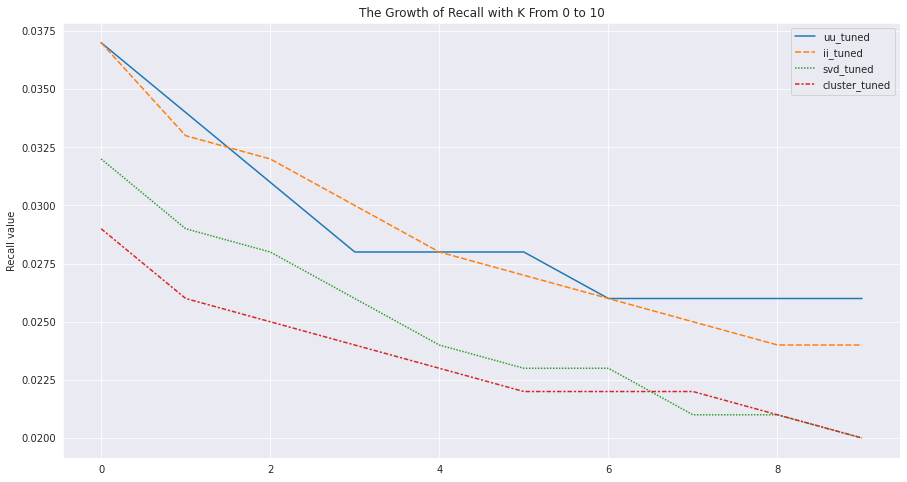

In [46]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid")
sns.lineplot(data=recall_data).set(title='The Growth of Recall with K From 0 to 10', ylabel='Recall value') #Check the growth of the recall value has been decreased as the K value increases.